<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Load & Preprocess the data
    </span>
</div>


In [1]:
import kagglehub
path = kagglehub.dataset_download('sabahesaraki/breast-ultrasound-images-dataset')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2DTranspose, BatchNormalization, ReLU, Conv2D, UpSampling2D, MaxPool2D, Dropout, MaxPooling2D, concatenate
from keras import Input, Model
import tensorflow as tf
import keras

from warnings import filterwarnings
filterwarnings('ignore')

2025-06-04 21:04:26.647388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749071066.868143      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749071066.932201      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
path = os.path.join(path , os.listdir(path)[0])

In [4]:
def load_data(cat_path):
  cat_path = os.path.join(path,cat_path)
  filenames = sorted(os.listdir(cat_path))

  images = [cv2.imread(os.path.join(cat_path, image))
  for image in filenames if image.endswith('.png')
  and all(mask not in image for mask in ['mask.png', 'mask_1', 'mask_2'])]

  images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

  masks = [cv2.imread(os.path.join(cat_path, mask), cv2.IMREAD_GRAYSCALE)
  for mask in filenames if mask.endswith('_mask.png')]

  return images, masks


In [5]:
benign_images, benign_masks = load_data('benign')
malignant_images, malignant_masks = load_data('malignant')
normal_images, normal_masks = load_data('normal')

In [6]:
len(benign_images), len(benign_masks), len(malignant_images), len(malignant_masks), len(normal_images), len(normal_masks)

(437, 437, 210, 210, 133, 133)

In [7]:
def data_preprocessing(images,masks, size):
  images = [cv2.resize(image,size) for image in images]
  masks = [cv2.resize(mask,size) for mask in masks]

  images = [image / 255.0 for image in images]
  masks = [mask / 255.0 for mask in masks]

  images = np.array(images)
  masks = np.array(masks)

  return images, masks

In [8]:
benign_images, benign_masks = data_preprocessing(benign_images,benign_masks,(256,256))
malignant_images, malignant_masks = data_preprocessing(malignant_images,malignant_masks,(256,256))
normal_images, normal_masks = data_preprocessing(normal_images,normal_masks,(256,256))

In [9]:
benign_images.shape, benign_masks.shape, malignant_images.shape, malignant_masks.shape, normal_images.shape, normal_masks.shape

((437, 256, 256, 3),
 (437, 256, 256),
 (210, 256, 256, 3),
 (210, 256, 256),
 (133, 256, 256, 3),
 (133, 256, 256))

In [10]:
images = np.concatenate((benign_images, malignant_images, normal_images), axis=0)
masks = np.concatenate((benign_masks, malignant_masks, normal_masks), axis=0)

In [11]:
combined = list(zip(images, masks))

np.random.shuffle(combined)

images, masks = zip(*combined)

images = np.array(images)
masks = np.array(masks)

train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Visualize Random Samples
    </span>
</div>


In [12]:
def visualize_random_sample(images, masks, n_samples=5):
  for i in range(n_samples):
    idx = np.random.randint(0, images.shape[0])
    image = images[idx]
    mask = masks[idx]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')

    axes[1].imshow(mask)
    axes[1].set_title('Mask')

    plt.show()

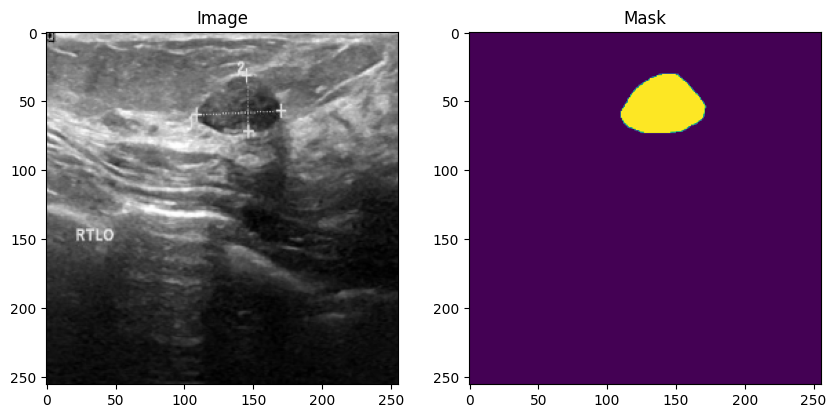

In [ ]:
visualize_random_sample(benign_images, benign_masks, 2)

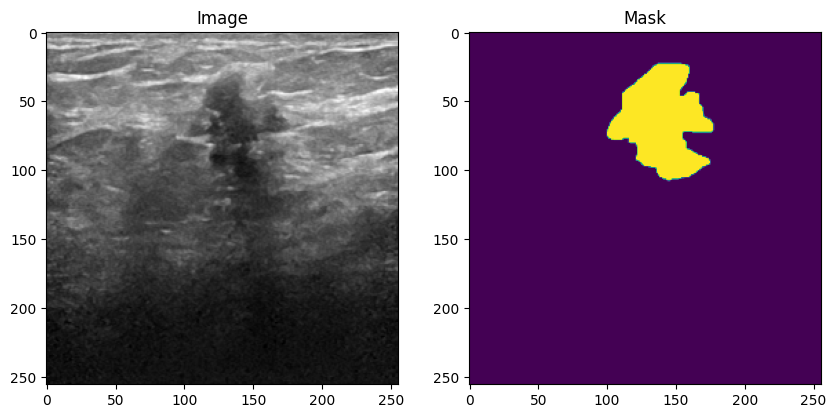

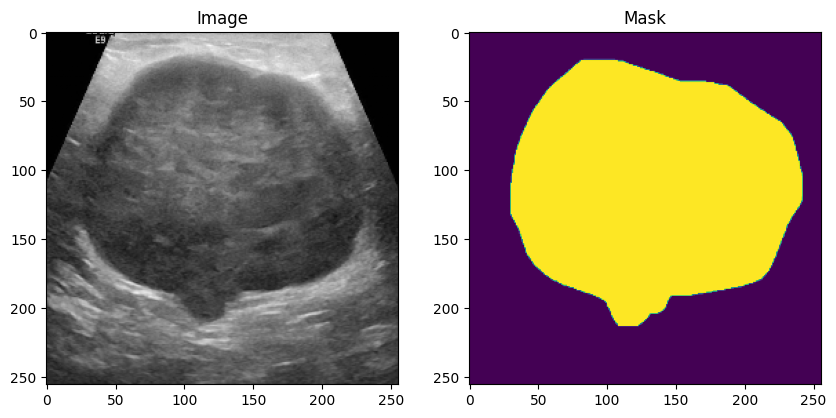

In [14]:
visualize_random_sample(malignant_images, malignant_masks, 2)

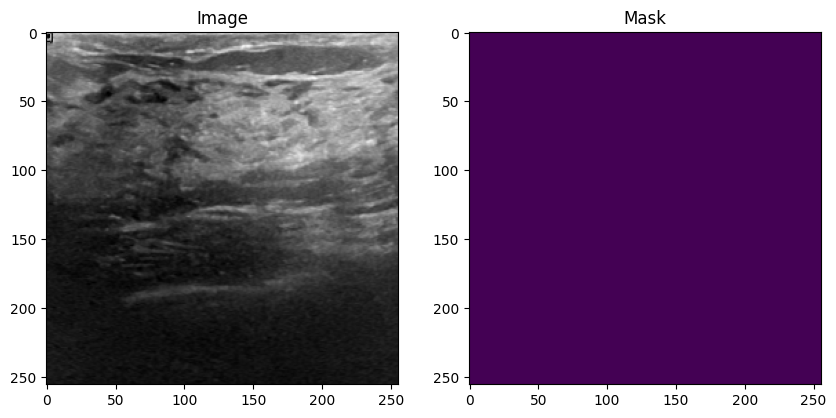

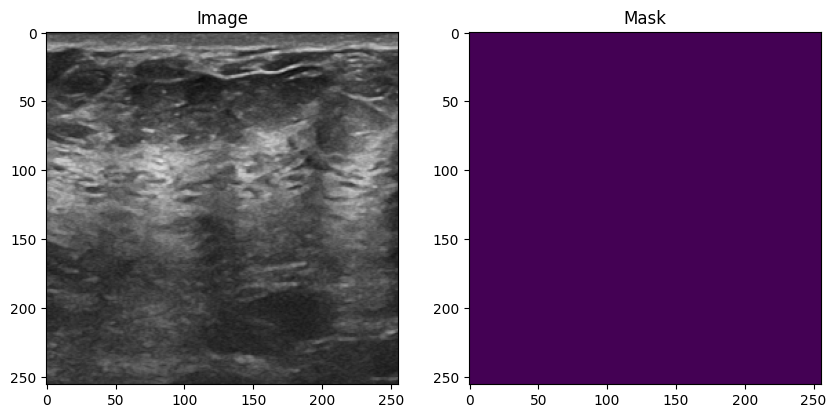

In [15]:
visualize_random_sample(normal_images, normal_masks, 2)

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         U-net Architecture
    </span>
</div>


In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2DTranspose, BatchNormalization, ReLU, Conv2D, UpSampling2D, MaxPool2D, Dropout, MaxPooling2D, concatenate
from keras import Input, Model
import tensorflow as tf
import keras

In [18]:
def conv_block(input, filters):
  conv = Conv2D(filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(input)
  conv = Conv2D(filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
  return conv

def encoder(input, filters):
  conv = conv_block(input, filters)
  pool = MaxPooling2D((2, 2))(conv)
  return conv, pool

def decoder(input, skip_features, filters):
  convT = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input)
  con = concatenate([convT, skip_features])
  conv = conv_block(con, filters)
  return conv

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Final Model
    </span>
</div>


In [19]:
def final_model(input_shape):
  input = Input(input_shape)

  s1, p1 = encoder(input, 64)
  s2, p2 = encoder(p1, 128)
  s3, p3 = encoder(p2, 256)
  s4, p4 = encoder(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder(b1, s4, 512)
  d2 = decoder(d1, s3, 256)
  d3 = decoder(d2, s2, 128)
  d4 = decoder(d3, s1, 64)

  output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(d4)

  model = Model(inputs=input, outputs=output, name='U-net')

  return model

In [20]:
model = final_model((256,256,3))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

I0000 00:00:1749071156.877180      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749071156.877969      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
history = model.fit(train_images, train_masks, epochs = 50, validation_data = (test_images,test_masks), verbose=1)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 312s 10s/step - accuracy: 0.8561 - loss: 0.4712 - val_accuracy: 0.9276 - val_loss: 0.2726
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9177 - loss: 0.2869 - val_accuracy: 0.9276 - val_loss: 0.2411
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9192 - loss: 0.2671 - val_accuracy: 0.9276 - val_loss: 0.2443
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9169 - loss: 0.2556 - val_accuracy: 0.9276 - val_loss: 0.2303
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9220 - loss: 0.2343 - val_accuracy: 0.9276 - val_loss: 0.2275
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9239 - loss: 0.2253 - val_accuracy: 0.9276 - val_loss: 0.2223
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9204 - loss: 0.2239 - val_accuracy: 0.9274 - val_loss: 0.2112
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9203 - loss: 0.2160 - val_accuracy: 0.9275 - val_los

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Evaluation
    </span>
</div>


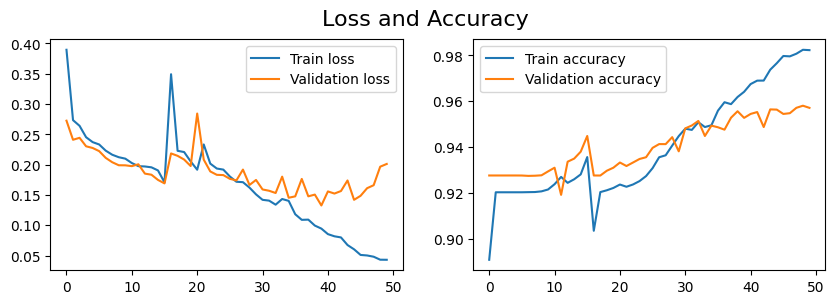

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

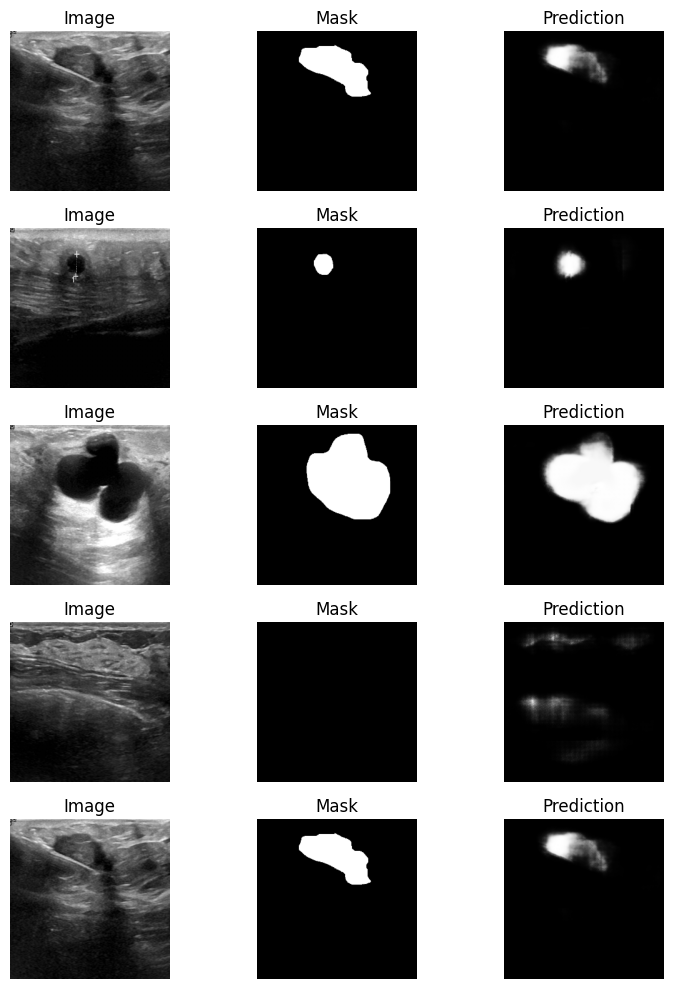

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(8,10))

j = np.random.randint(0, test_images.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(test_images[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(test_masks[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(test_images[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
    for a in ax[i]:
        a.axis('off')
    plt.tight_layout()

plt.show()

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Save Model
    </span>
</div>


In [ ]:
model.save('unet_model.h5')